# TensorFlow Basics
## Numpy vs TF
Start with a simple architecture to outline how strikingly similar are numpy and tensorflow.

![Computational Graph](./assets/tf_comp_graph.png)

The following is forward propagation and gradient computation in numpy:

In [1]:
import numpy as np
np.random.seed(0)

N, D = 3, 4

x = np.random.randn(N, D)
y = np.random.randn(N, D)
z = np.random.randn(N, D)

# Forward prop
a = x * y
b = a + z
c = np.sum(b)

# Backward prop
grad_c = 1 # Gradient of c with respect to c 
grad_b = grad_c * np.ones((N, D))
grad_a = grad_b.copy()
grad_z = grad_b.copy() 
grad_x = grad_a * y
grad_y = grad_a * x

print "Gradient x:", grad_x
print "Graident y:", grad_y
print "Gradient z:", grad_z

Gradient x: [[ 0.76103773  0.12167502  0.44386323  0.33367433]
 [ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]]
Graident y: [[ 1.76405235  0.40015721  0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]
Gradient z: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


The following is forward propagation and gradient computation in tensorflow:

In [2]:
import tensorflow as tf
np.random.seed(0)

N, D = 3, 4

x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = tf.placeholder(tf.float32)

a = x * y
b = a + z 
c = tf.reduce_sum(b)

grad_x, grad_y, grad_z = tf.gradients(c, [x, y, z])

with tf.Session() as sess:
    values = {
        x: np.random.randn(N, D),
        y: np.random.randn(N, D),
        z: np.random.randn(N, D),
    }

    out = sess.run([c, grad_x, grad_y, grad_z], feed_dict=values)
    c_val, grad_x_val, grad_y_val, grad_z_val = out

print "Gradient x:", grad_x_val
print "Graident y:", grad_y_val
print "Gradient z:", grad_z_val

Gradient x: [[ 0.7610377   0.12167501  0.44386324  0.33367434]
 [ 1.4940791  -0.20515826  0.3130677  -0.85409576]
 [-2.5529897   0.6536186   0.8644362  -0.742165  ]]
Graident y: [[ 1.7640524   0.4001572   0.978738    2.2408931 ]
 [ 1.867558   -0.9772779   0.95008844 -0.1513572 ]
 [-0.10321885  0.41059852  0.14404356  1.4542735 ]]
Gradient z: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


## Feedforward Neural Network
The following is an example of building a fully connected 3-layer neural network with TensorFlow. As you can see that the code isn't that much different from numpy as like the examples above. Tensorflow shares many similar API with numpy.

In [3]:
N, D, H = 64, 1000, 100
with tf.device('/cpu:0'):
    x = tf.placeholder(tf.float32, shape=(N, D))
    y = tf.placeholder(tf.float32, shape=(N, D))
    w1 = tf.placeholder(tf.float32, shape=(D, H))
    w2 = tf.placeholder(tf.float32, shape=(H, D))
    
    h = tf.maximum(tf.matmul(x, w1), 0)
    y_pred = tf.matmul(h, w2)
    diff = y_pred - y
    loss = tf.reduce_mean(tf.reduce_sum(diff ** 2, axis=1))
    
    grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])
    
with tf.Session() as sess:
    values = {
        x: np.random.randn(N, D),
        y: np.random.randn(N, D),
        w1: np.random.randn(D, H),
        w2: np.random.randn(H, D),
    }
    
    learning_rate = 1e-5
    for t in range(50):
        out = sess.run([loss, grad_w1, grad_w2], feed_dict=values)
        loss_val, grad_w1_val, grad_w2_val = out
        
        # Perform parameter updates and learning
        values[w1] -= learning_rate * grad_w1_val
        values[w2] -= learning_rate * grad_w2_val 

### Define Graph
The workflow in TensorFlow is splitted into two. First we define the computational graph and decide on what are the gradients we are looking for, e.g.
```python
grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])
```

```python
x = tf.placeholder(tf.float32, shape=(N, D))
y = tf.placeholder(tf.float32, shape=(N, D))
w1 = tf.placeholder(tf.float32, shape=(D, H))
w2 = tf.placeholder(tf.float32, shape=(H, D))
h = tf.maximum(tf.matmul(x, w1), 0)
y_pred = tf.matmul(h, w2)
diff = y_pred - y
loss = tf.reduce_mean(tf.reduce_sum(diff ** 2, axis=1))
grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])
```

### Run Session
Then we run the graph many times and perform updates on each variable/placeholder. Remember that whatever placeholder we used, we need to feed them with values using key word argument `feed_dict` in `run()` function.
```python
with tf.Session() as sess:
    values = {
        x: np.random.randn(N, D),
        y: np.random.randn(N, D),
        w1: np.random.randn(D, H),
        w2: np.random.randn(H, D),
    }

    out = sess.run([loss, grad_w1, grad_w2], feed_dict=values)
    loss_val, grad_w1_val, grad_w2_val = out
```

### Performance Bottleneck
Notice that vanilla `numpy` only works with CPU, the output of `run()` is in numpy array. This creates a problem when we want to run our `tf` code on GPU because we are basically copying values from GPU to CPU and CPU back to GPU. This can create a bottleneck on huge dataset. 

There is a solution, instead of using `placeholder`, use `Variable`.

```python
w1 = tf.Variable(tf.random_normal((D, H)))
w2 = tf.Variable(tf.random_normal((H, D)))
``` 

These variables are values that live inside the computational graph and will persist throughout training. And then we need to specify how we'd like to update these variables per iteration through `session.Run()` in Tensorflow.

```python
grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])
new_w1 = w1.assign(w1 - learning_rate * grad_w1)
new_w2 = w2.assign(w2 - learning_rate * grad_w2)
```

In order to actually compute and update these values, we need to assign them to a dummy node and tell tensor flow that we need the node to be computed in each iteration.

```python
weight_updates = tf.group(new_w1, new_w2)
with tf.Session() as sess:
    for t in range(50):
        loss_val, _ = sess.run([loss, weight_updates], feed_dict=values)
```

## TensorFlow API
### Optimizers
Tensor flow actually gives us API to run gradient descent. The API lives inside `tf.train`. Basically what it does is similar to what's written above. It performs the updates by calling `assign` on the `tf.Variable`s and then group them into a dummy node and execute the computation per iteration.

```python
optimizer = tf.train.GradientDescentOptimizer(1e-5)
weight_updates = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    values = { x: np.random.randn(N, D), y: np.random.randn(N, D) }
    losses = []
    for t in range(50):
        loss_val, _ = sess.run([loss, weight_updates], feed_dict=values)
        losses.append(loss_val)
```

### Losses
If `tf` gives optimizier, it must also other conveninent functions like L1 and L2 losses. That's right, it does!

```python
loss = tf.losses.mean_squared_error(y_pred, y)
```

### Layers
So far we have omitted all the nitty-gritty details of defining biases and performing xavier initialization for simplicity. It'd take a good amount of code to carefully piece everything together if we were to write them from scratch. And again, `tf` provides everything out of the box for us!

```python 
init = tf.contrib.layers.xavier_initializer()
h = tf.layers.dense(inputs=x, units=H, activation=tf.nn.relu, kernel_initializer=init)
y_pred = tf.layers.dense(inputs=h, units=D, kernel_initializer=init)
loss = tf.losses.mean_squared_error(y_pred, y)
```

This `tf.layers` library provides architectural setup for us so we don't have to create the layer manually. All the biases and weight initializations are set right out of the box!

### Keras
Keras is a wrapper around TensorFlow. It provides more readable API at the cost of flexibility. However, most projects don't actually require the flexibility of TensorFlow. Keras works well in most cases.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

N, D, H = 64, 1000, 100

model = Sequential()
model.add(Dense(input_dim=D, output_dim=H))
model.add(Activation('relu'))
model.add(Dense(input_dim=H, output_dim=D))

optimizer = SGD(lr=1e0)
model.compile(loss='mean_squared_error', optimizer=optimizer)

x = np.random.randn(N, D)
y = np.random.randn(N, D)
history = model.fit(x, y, nb_epoch=50, batch_size=N, verbose=0)
```

## More TF Examples
Using the provided API, we can now write a more optimized graph:

['w1' 'w2']


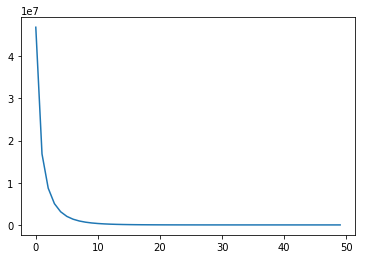

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
import numpy as np

"""
Two-layer ReLU fully connected network running on Tensorflow with optimized the variables, i.e. we are not going to load
weights from CPU to GPU and GPU back to CPU. The weights will stay within the graph throughout training.
"""

N, D, H = 64, 1000, 100
with tf.device('/cpu:0'):
    # Define our computational graph
    x = tf.placeholder(tf.float32, shape=(N,D))
    y = tf.placeholder(tf.float32, shape=(N,D))

    # Notice that I use Variable instead of placeholder to avoid transfering values from GPU to CPU if
    # we were to run this with GPU
    w1 = tf.Variable(tf.random_normal((D, H)), name="w1")
    w2 = tf.Variable(tf.random_normal((H, D)), name="w2")

    h = tf.maximum(tf.matmul(x, w1), 0)
    y_pred = tf.matmul(h, w2)
    diff = y_pred - y

    # L2 Loss
    loss = tf.reduce_mean(tf.reduce_sum(diff ** 2, axis=1))

    # Telling TensorFlow the update rules for the tf Variables
    learning_rate = 1e-5
    grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])
    new_w1 = w1.assign(w1 - learning_rate * grad_w1)
    new_w2 = w2.assign(w2 - learning_rate * grad_w2)

    # Create a new dummy node to explicitly tell TensorFlow to NOT SKIP computing it
    weight_updates = tf.group(new_w1, new_w2)

with tf.Session() as sess:
    print sess.run(tf.report_uninitialized_variables())
    sess.run(tf.global_variables_initializer())
    # Vectors x and y should not live in the graph as variables because we actually want to load many different
    # mini batch into the graph for SGD.
    values = {
        x: np.random.randn(N, D),
        y: np.random.randn(N, D)
    }
    
    time_steps = []
    losses = []
    for t in range(50):
        loss_val, _ = sess.run([loss, weight_updates], feed_dict=values)
        time_steps.append(t)
        losses.append(loss_val)
    
    plt.plot(time_steps, losses)
    plt.show()

Now using layers, we have a fully optimized example below:

Instructions for updating:
Use the retry module or similar alternatives.


Algorithm took 6.52738213539 seconds using /cpu:0


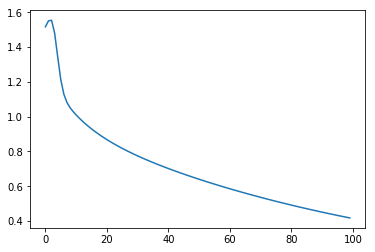

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
import numpy as np
from timeit import default_timer

device_name, N, D, H = '/cpu:0', 1000, 1000, 1000

with tf.device(device_name):
    x = tf.placeholder(tf.float32, shape=(N, D))
    y = tf.placeholder(tf.float32, shape=(N, D))

    xavier_init = tf.contrib.layers.xavier_initializer()
    h = tf.layers.dense(inputs=x, units=H, activation=tf.nn.relu, kernel_initializer=xavier_init)
    y_pred = tf.layers.dense(inputs=h, units=D, kernel_initializer=xavier_init)
    loss = tf.losses.mean_squared_error(y_pred, y)

    optimizer = tf.train.GradientDescentOptimizer(7e0)
    weight_updates = optimizer.minimize(loss)

start = default_timer()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    values = {
        x: np.random.randn(N, D),
        y: np.random.randn(N, D)
    }

    losses, iters = [], []
    for t in range(100):
        loss_val, _ = sess.run([loss, weight_updates], feed_dict=values)
        losses.append(loss_val)
        iters.append(t)

duration = default_timer() - start
print 'Algorithm took %s seconds using %s' % (duration, device_name)
plt.plot(iters, losses)
plt.show()

# PyTorch
PyTorch is another popular framework for machine learning from Facebook. Here is a quick comparison between TensorFlow and PyTorch.

## Three Levels of Abstractions
| PyTorch | TensorFlow |
|----------------------------------------------------------------------|------------------------------|
|Tensor - Imperative ndarray but runs on GPU                           |Numpy array                   |
|Variable - Node in a computational graph; stores data and gradient    |Tensor, Variable, Placeholder |
|Module - A neural network layer; may store state or learnable weights |tf.layers, TFSlim, or TFLearn |


### Tensors
```python
import torch

dtype = torch.FloatTensor # Or run it on GPU by using torch.cuda.FloatTensor
N, D_in, H, D_out = 64, 1000, 100, 10
x = torch.randn(N, D_in).type(dtype)
y = torch.randn(N, D_out).type(dtype)
w1 = torch.randn(D_in, H).type(dtype)
w2 = torch.randn(H, D_out).type(dtype)

learning_rate = 1e-6
for t in range(500):
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    loss = (y_pred - y).pow(2).sum()
    
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)
    
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
```

It looks just like `numpy` code!

### Autograd
A PyTorch `Variable` is a node in a computational graph. `x.data` is a `Tensor`, `x.grad` is a `Variable` of gradients with the same shape as `x.data`, and `x.grad.data` is a `Tensor` of gradients.

PyTorch `Tensor` and `Variable` have the same API. `Variable`s remember how they were created for backprop.
```python
import torch
from torch.autograd import Variable

N, D_in, H, D_out = 64, 1000, 100, 10
x = Variable(torch.randn(N, D_in), requires_grad=False)
y = Variable(torch.randn(N, D_out), requires_grad=False)
w1 = Variable(torch.randn(D_in, H), requires_grad=True)
w2 = Variable(torch.randn(H, D_out), requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    loss = (y_pred - y).pow(2).sum()
    
    if w1.grad: w1.grad.data.zero()
    if w2.grad: w2.grad.data.zero()
    loss.backward()
    
    w1.data -= learning_rate * w1.grad.data
    w2.data -= learning_rate * w2.grad.data
```    

As the name suggests, `autograd` computes gradient for you automatically.

### Define Your Own
You can define your own autograd functions by writing forward and backward props for tensors.
```python
class ReLU(torch.autograd.Function):
    def forward(self, x):
        self.save_for_backward(x)
        return x.clamp(min=0)
    
    def backward(self, grad_y):
        x, = self.saved_tensors
        grad_input = grad_y.clone()
        grad_input[x < 0] = 0
        return grad_input
```

### Optimizer
PyTorch offers a similar package to TensorFlow's `keras`. 

```python
import torch
from torch.autograd import Variable

N, D_in, H, D_out = 64, 1000, 100, 10

x = Variable(torch.randn(N, D_in))
y = Variable(torch.randn(N, D_out), requires_grad=False)

model = torch.nn.Sequential(torch.nn.Linear(D_in, H), torch.nn.ReLU(), torch.nn.Linear(H, D_out))
loss_fn = torch.nn.MSELoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(500):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
```

### Modules
A PyTorch module is a neural network layer; it inputs and outputs `Variable`s. Modules can contain weights as `Variable` and other modules. You can define your own modules!

```python
import torch
from torch.autograd import Variable

class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred
    
N, D_in, H, D_out = 64, 1000, 100, 10

x = Variable(torch.randn(N, D_in))
y = Variable(torch.randn(N, D_out), requires_grad=False)

model = TwoLayerNet(D_in, H, D_out)

criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for t in range(500):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```